<a href="https://colab.research.google.com/github/lucasoliveira13/Cartpole/blob/main/CartpoleFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import random
import gym
import numpy as np
np.random.seed(1337)
from collections import deque
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
import tensorflow as tf
import matplotlib.pyplot

def Modelo(input_shape, action_space):
    X_input = Input(input_shape)
    X = Dense(512, input_shape=input_shape, activation="relu", kernel_initializer='he_uniform')(X_input)
    X = Dense(256, activation="relu", kernel_initializer='he_uniform')(X)
    X = Dense(64, activation="relu", kernel_initializer='he_uniform')(X)
    X = Dense(action_space, activation="linear", kernel_initializer='he_uniform')(X)
    modelo = Model(inputs = X_input, outputs = X, name='DQN')
    modelo.compile(loss="mse", optimizer=tf.optimizers.RMSprop(lr=0.00025, rho=0.95, epsilon=0.01), metrics=["accuracy"])
    modelo.summary()
    return modelo


In [3]:
def treino(agente, ambiente, episodios=500, epsilon_min=0.001, epsilon_decay=0.999, train_start=1000):
      state_size = ambiente.observation_space.shape[0]
      listrecomp = []
      for e in range(episodios):
         recompensa_ep= 0.0
         estado = ambiente.reset()
         estado = np.reshape(estado, [1, state_size])
         fim = False
         i = 0
         while not fim:
            #self.amb.render()
            acao = agente.act(estado)
            prox_estado, recompensa, fim, _ = ambiente.step(acao)
            prox_estado = np.reshape(prox_estado,[1, state_size])
            if not fim or i == ambiente._max_episode_steps-1:
                recompensa = recompensa
            else:
                recompensa = -100
            agente.lembrar(estado, acao, recompensa, prox_estado, fim)
            estado = prox_estado
            recompensa_ep += recompensa
            i+=1
            if len(agente.memory) > train_start:
                if agente.epsilon > epsilon_min:
                    agente.epsilon *= epsilon_decay
            agente.replay()
         print("ep: {}/{}, pontuacao: {}, e: {:.2}".format(e+1, episodios, recompensa_ep, agente.epsilon))
         listrecomp.append(recompensa_ep)
         if recompensa_ep == 10:
              return listrecomp
        
      return listrecomp

In [4]:
def teste(agente, ambiente, episodios=1,epsilon=0.001):
      state_size=ambiente.observation_space.shape[0]
      action_size = ambiente.action_space.n
      #print("CARREGOU")
      agente.epsilon = epsilon
      recomp=0.0
      for e in range (episodios):
          estado = ambiente.reset()
          estado = np.reshape(estado, [1,state_size])
          fim = False
          i = 0 
          while not fim:
            #self.amb.render()
            acao = agente.act(estado)
            prox_estado, recompensa, fim, _ = ambiente.step(acao)
            estado = np.reshape(prox_estado, [1,state_size])
            if not fim or i == ambiente._max_episode_steps-1:
                recompensa = recompensa
            else:
                recompensa = -100
            recomp+=recompensa    
            i +=1
          #print("episodio: {}/{}, pontuacao: {}".format(e, episodios, recomp))
      return recomp       

In [5]:
def run():
      amb = gym.make("CartPole-v1")
      agente = DQNAgent(amb)
      fim = False
      epsilon_atual = 1.0
      maioria = 0.0
      recomp_data = []
      while not fim:     
        agente.epsilon = epsilon_atual
        print("---------INICIO DO TREINO----------")
        recomp_treino = treino(agente,amb)
        plot(recomp_treino,len(recomp_treino))
        print("-----------FIM DO TREINO----------")
        epsilon_atual = agente.epsilon
        print("------------INICIO DOS TESTES------------")
        for e in range (20):
          recomp_teste = teste(agente,amb)
          recomp_data.append(recomp_teste)
          print("episodio: {}/20, pontuacao: {}".format(e+1, recomp_teste))
          if recomp_teste >= 495:
             maioria+=1
        fim = maioria >= 18
        plot(recomp_data,len(recomp_data))
        print("-------------FIM DOS TESTES----------")
      agente.save("cartpole-dqn.h5")

In [6]:
def plot(lista,tamanho):
    episodios = []
    for e in range(tamanho):
      episodios.append(e)
    matplotlib.pyplot.plot(episodios,lista)
    matplotlib.pyplot.xlabel("Episódios")
    matplotlib.pyplot.ylabel("Recompensas")
    if tamanho == 20:
        matplotlib.pyplot.title("Métricas do Teste")
    else:
         matplotlib.pyplot.title("Métricas do Treino")
    matplotlib.pyplot.show()


In [7]:
class DQNAgent:

    def __init__(self,ambiente):
        # self.amb = gym.make('CartPole-v1')
        self.state_size = ambiente.observation_space.shape[0]
        self.action_size = ambiente.action_space.n
        # self.EPISODES = 500
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95 
        self.epsilon = 1.0
        # self.epsilon_min = 0.001
        # self.epsilon_decay = 0.999
        self.batch_size = 64
        self.train_start = 1000
        self.modelo = Modelo(input_shape=(self.state_size,), action_space = self.action_size)

    def replay (self):
      if len(self.memory) < self.train_start:
        return
    
      experiencia = random.sample(self.memory, min(len(self.memory), self.batch_size))
      estado = np.zeros((self.batch_size, self.state_size))
      prox_estado = np.zeros((self.batch_size, self.state_size))
      acao, recompensa, fim = [],[],[]

      for i in range(self.batch_size):
         estado[i] = experiencia[i][0]
         acao.append(experiencia[i][1])
         recompensa.append(experiencia[i][2])
         prox_estado[i] = experiencia[i][3]
         fim.append(experiencia[i][4])

      target = self.modelo.predict(estado)    
      target_prox = self.modelo.predict(prox_estado)

      for i in range(self.batch_size):
         if fim[i]:
            target[i][acao[i]] = recompensa[i]
         else:    
            target[i][acao[i]] = recompensa[i] + self.gamma * (np.amax(target_prox[i]))
      self.modelo.fit(estado, target, batch_size=self.batch_size, verbose=0)


    def act(self, state):
       if np.random.random() <= self.epsilon:
          return random.randrange(self.action_size)
       else:
          return np.argmax(self.modelo.predict(state)) 

    def load(self, name):
      self.modelo = load_model(name)
    
    def save(self, name):
      self.modelo.save(name)
    
    def lembrar(self, estado, acao, recompensa, prox_estado, fim):
      self.memory.append((estado, acao, recompensa, prox_estado, fim))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "DQN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 512)               2560      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 150,466
Trainable params: 150,466
Non-trainable params: 0
_________________________________________________________________
---------INICIO DO TREINO----------
ep: 1/500, pontuacao: -81.0, e: 1.0
ep: 2/500, pontuacao: -77.0, e: 1.0
ep: 3/500, pont

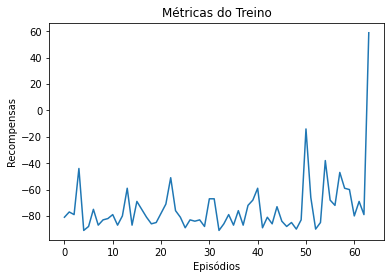

-----------FIM DO TREINO----------
------------INICIO DOS TESTES------------
episodio: 1/20, pontuacao: 298.0
episodio: 2/20, pontuacao: 500.0
episodio: 3/20, pontuacao: 221.0
episodio: 4/20, pontuacao: 275.0
episodio: 5/20, pontuacao: 220.0
episodio: 6/20, pontuacao: 500.0
episodio: 7/20, pontuacao: 234.0
episodio: 8/20, pontuacao: 235.0
episodio: 9/20, pontuacao: 330.0
episodio: 10/20, pontuacao: 255.0
episodio: 11/20, pontuacao: 500.0
episodio: 12/20, pontuacao: 215.0
episodio: 13/20, pontuacao: 281.0
episodio: 14/20, pontuacao: 296.0
episodio: 15/20, pontuacao: 316.0
episodio: 16/20, pontuacao: 500.0
episodio: 17/20, pontuacao: 271.0
episodio: 18/20, pontuacao: 500.0
episodio: 19/20, pontuacao: 326.0
episodio: 20/20, pontuacao: 240.0


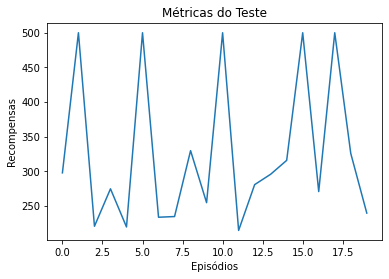

-------------FIM DOS TESTES----------
---------INICIO DO TREINO----------
ep: 1/500, pontuacao: 237.0, e: 0.34


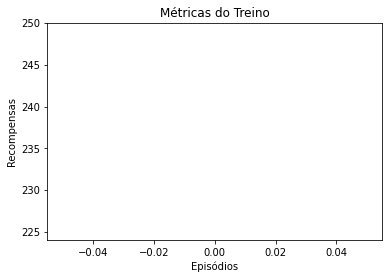

-----------FIM DO TREINO----------
------------INICIO DOS TESTES------------
episodio: 1/20, pontuacao: 89.0
episodio: 2/20, pontuacao: 139.0
episodio: 3/20, pontuacao: 141.0
episodio: 4/20, pontuacao: 142.0
episodio: 5/20, pontuacao: 141.0
episodio: 6/20, pontuacao: 81.0
episodio: 7/20, pontuacao: 183.0
episodio: 8/20, pontuacao: 127.0
episodio: 9/20, pontuacao: 95.0
episodio: 10/20, pontuacao: 78.0
episodio: 11/20, pontuacao: 105.0
episodio: 12/20, pontuacao: 71.0
episodio: 13/20, pontuacao: 139.0
episodio: 14/20, pontuacao: 95.0
episodio: 15/20, pontuacao: 155.0
episodio: 16/20, pontuacao: 197.0
episodio: 17/20, pontuacao: 117.0
episodio: 18/20, pontuacao: 112.0
episodio: 19/20, pontuacao: 225.0
episodio: 20/20, pontuacao: 131.0


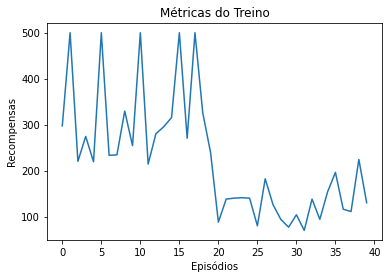

-------------FIM DOS TESTES----------
---------INICIO DO TREINO----------
ep: 1/500, pontuacao: 92.0, e: 0.28


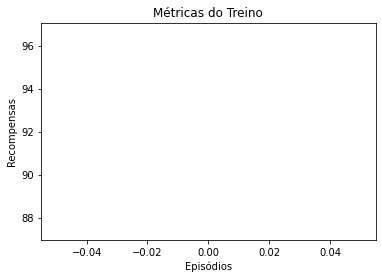

-----------FIM DO TREINO----------
------------INICIO DOS TESTES------------
episodio: 1/20, pontuacao: 93.0
episodio: 2/20, pontuacao: 170.0
episodio: 3/20, pontuacao: 87.0
episodio: 4/20, pontuacao: 127.0
episodio: 5/20, pontuacao: 177.0
episodio: 6/20, pontuacao: 144.0
episodio: 7/20, pontuacao: 165.0
episodio: 8/20, pontuacao: 72.0
episodio: 9/20, pontuacao: 71.0
episodio: 10/20, pontuacao: 179.0
episodio: 11/20, pontuacao: 105.0
episodio: 12/20, pontuacao: 251.0
episodio: 13/20, pontuacao: 123.0
episodio: 14/20, pontuacao: 40.0
episodio: 15/20, pontuacao: 98.0
episodio: 16/20, pontuacao: 125.0
episodio: 17/20, pontuacao: 227.0
episodio: 18/20, pontuacao: 112.0
episodio: 19/20, pontuacao: 149.0
episodio: 20/20, pontuacao: 98.0


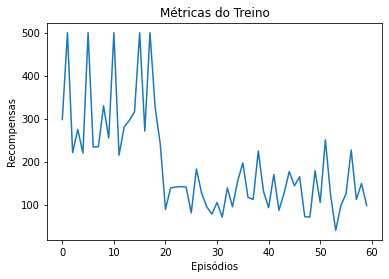

-------------FIM DOS TESTES----------
---------INICIO DO TREINO----------
ep: 1/500, pontuacao: 74.0, e: 0.24


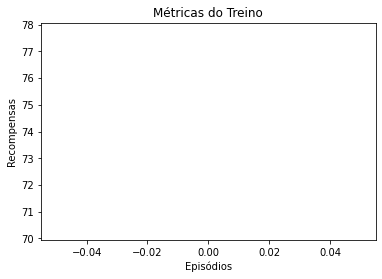

-----------FIM DO TREINO----------
------------INICIO DOS TESTES------------
episodio: 1/20, pontuacao: 78.0
episodio: 2/20, pontuacao: 92.0
episodio: 3/20, pontuacao: 103.0
episodio: 4/20, pontuacao: 85.0
episodio: 5/20, pontuacao: 109.0
episodio: 6/20, pontuacao: 43.0
episodio: 7/20, pontuacao: 43.0
episodio: 8/20, pontuacao: 137.0
episodio: 9/20, pontuacao: 117.0
episodio: 10/20, pontuacao: 59.0
episodio: 11/20, pontuacao: 97.0
episodio: 12/20, pontuacao: 112.0
episodio: 13/20, pontuacao: 177.0
episodio: 14/20, pontuacao: 59.0
episodio: 15/20, pontuacao: 72.0
episodio: 16/20, pontuacao: 144.0
episodio: 17/20, pontuacao: 57.0
episodio: 18/20, pontuacao: 151.0
episodio: 19/20, pontuacao: 91.0
episodio: 20/20, pontuacao: 104.0


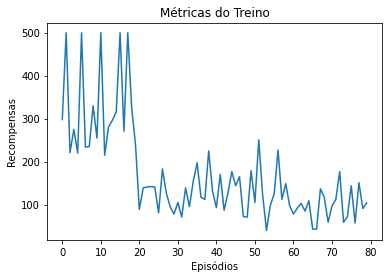

-------------FIM DOS TESTES----------
---------INICIO DO TREINO----------
ep: 1/500, pontuacao: 91.0, e: 0.19


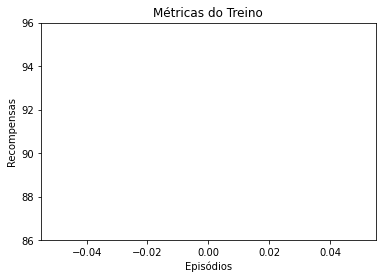

-----------FIM DO TREINO----------
------------INICIO DOS TESTES------------
episodio: 1/20, pontuacao: 97.0
episodio: 2/20, pontuacao: 217.0
episodio: 3/20, pontuacao: 75.0
episodio: 4/20, pontuacao: 205.0
episodio: 5/20, pontuacao: 89.0
episodio: 6/20, pontuacao: 68.0
episodio: 7/20, pontuacao: 132.0
episodio: 8/20, pontuacao: 202.0
episodio: 9/20, pontuacao: 340.0
episodio: 10/20, pontuacao: 200.0
episodio: 11/20, pontuacao: 90.0
episodio: 12/20, pontuacao: 107.0
episodio: 13/20, pontuacao: 97.0
episodio: 14/20, pontuacao: 176.0
episodio: 15/20, pontuacao: 110.0
episodio: 16/20, pontuacao: 145.0
episodio: 17/20, pontuacao: 102.0
episodio: 18/20, pontuacao: 96.0
episodio: 19/20, pontuacao: 64.0
episodio: 20/20, pontuacao: 88.0


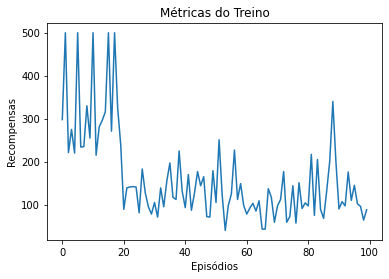

-------------FIM DOS TESTES----------
---------INICIO DO TREINO----------
ep: 1/500, pontuacao: 55.0, e: 0.17


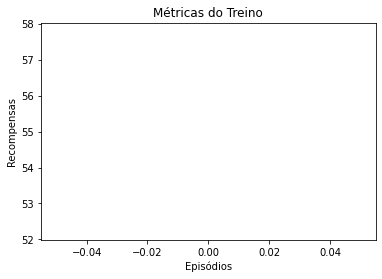

-----------FIM DO TREINO----------
------------INICIO DOS TESTES------------
episodio: 1/20, pontuacao: 108.0
episodio: 2/20, pontuacao: 88.0
episodio: 3/20, pontuacao: 230.0
episodio: 4/20, pontuacao: 91.0
episodio: 5/20, pontuacao: 51.0
episodio: 6/20, pontuacao: 78.0
episodio: 7/20, pontuacao: 93.0
episodio: 8/20, pontuacao: 90.0
episodio: 9/20, pontuacao: 89.0
episodio: 10/20, pontuacao: 73.0
episodio: 11/20, pontuacao: 102.0
episodio: 12/20, pontuacao: 185.0
episodio: 13/20, pontuacao: 59.0
episodio: 14/20, pontuacao: 126.0
episodio: 15/20, pontuacao: 65.0
episodio: 16/20, pontuacao: 53.0
episodio: 17/20, pontuacao: 155.0
episodio: 18/20, pontuacao: 89.0
episodio: 19/20, pontuacao: 56.0
episodio: 20/20, pontuacao: 61.0


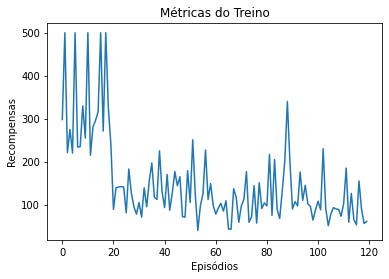

-------------FIM DOS TESTES----------
---------INICIO DO TREINO----------
ep: 1/500, pontuacao: 168.0, e: 0.13


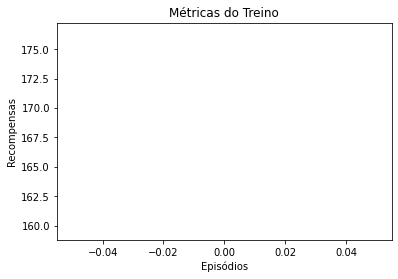

-----------FIM DO TREINO----------
------------INICIO DOS TESTES------------
episodio: 1/20, pontuacao: 92.0
episodio: 2/20, pontuacao: 164.0
episodio: 3/20, pontuacao: 69.0
episodio: 4/20, pontuacao: 110.0
episodio: 5/20, pontuacao: 75.0
episodio: 6/20, pontuacao: 110.0
episodio: 7/20, pontuacao: 122.0
episodio: 8/20, pontuacao: 120.0
episodio: 9/20, pontuacao: 128.0
episodio: 10/20, pontuacao: 68.0
episodio: 11/20, pontuacao: 78.0
episodio: 12/20, pontuacao: 172.0
episodio: 13/20, pontuacao: 108.0


KeyboardInterrupt: ignored

In [8]:
if __name__ == "__main__":
    run()